In [2]:
# ======= Step 0: 导入需要的库 =======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# ======= Step 1:  数据准备+参数设置 =======

data = pd.read_csv("../10_Data_Clean/xgboost_data.csv")

data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK', 'YEAR_OF_LAST_FIRE', 'YEARS_SINCE_LAST_FIRE',
       'CUMULATIVE_ACRES_BURNED_LAST_3YRS', 'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
       'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
       'FIRE_EXPOSED_x_Median_Household_Income',
       'FIRE_EXPOSED_x_Below_Poverty_Rate', 'ROLLING_3yr_PRICE_CHANGE_STD'],
      dty

## 1. EDA

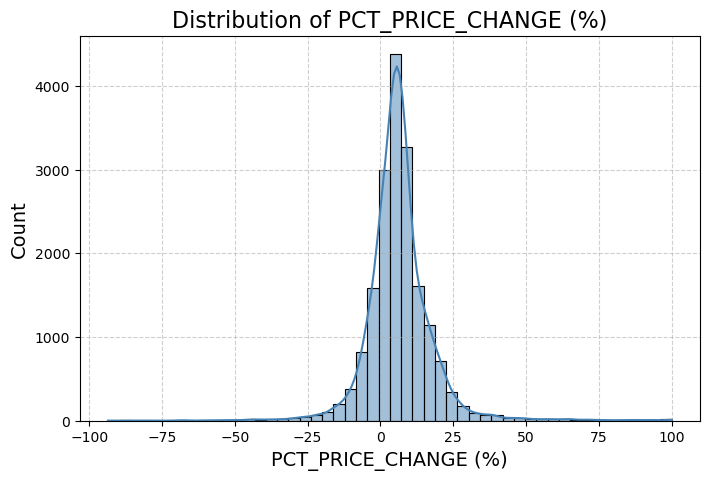

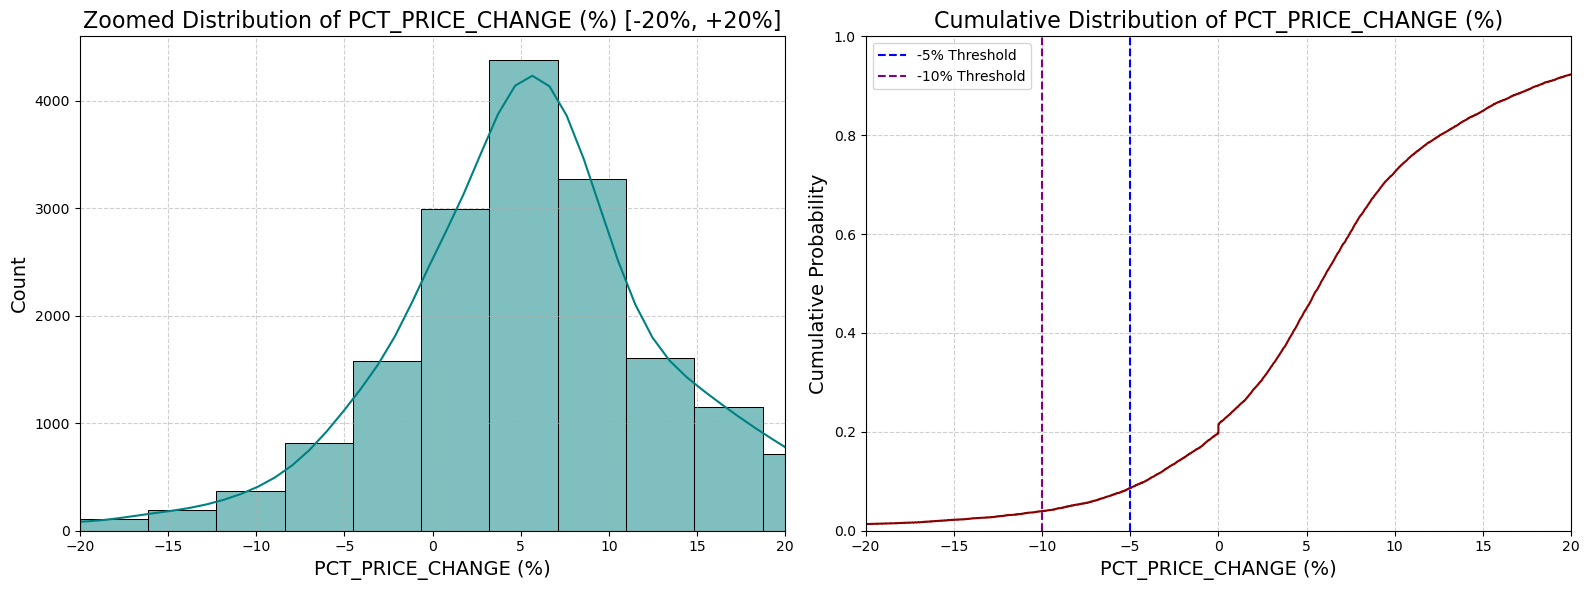

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(data['PCT_PRICE_CHANGE (%)'], bins=50, kde=True, color='steelblue')

plt.title('Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
plt.xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

sns.histplot(
    data['PCT_PRICE_CHANGE (%)'],
    bins=50,
    kde=True,
    color='teal',
    ax=axes[0]
)
axes[0].set_xlim(-20, 20)
axes[0].set_title('Zoomed Distribution of PCT_PRICE_CHANGE (%) [-20%, +20%]', fontsize=16)
axes[0].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)

# ---- CDF (ECDF) ----
sns.ecdfplot(
    data['PCT_PRICE_CHANGE (%)'],
    color='darkred',
    ax=axes[1]
)
axes[1].set_title('Cumulative Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
axes[1].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)

#  -5% & -10% 
axes[1].axvline(x=-5, color='blue', linestyle='--', label='-5% Threshold')
axes[1].axvline(x=-10, color='purple', linestyle='--', label='-10% Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()


1. Zoomed-in Distribution [-20%, +20%]
The histogram of PCT_PRICE_CHANGE (%) zoomed into the [-20%, +20%] range shows:
A unimodal distribution peaking around +5%, suggesting that modest price growth was the most common outcome.
Smooth transitions between price change ranges without visible discontinuities or clustering artifacts.
Severe Drops (<-10%) are rare but evident, justifying special categorization for high-risk zones.
Medium Drops (-10% to -5%) have moderate density, providing sufficient sample size for a stable classification boundary.
The main body of data lies between -5% and +15%, supporting the economic relevance of mild market fluctuations.

**Visual inspection of the zoomed histogram supports the selection of the -5% and -10% thresholds by revealing that these cuts fall at natural points of declining frequency, ensuring that severity classes reflect meaningful differences in market dynamics.**

2. Overall Cumulative Distribution (CDF)
The cumulative distribution function (CDF) of PCT_PRICE_CHANGE (%) reveals a standard S-shaped curve, typical for unimodal, slightly skewed data:
Approximately 10% of observations experienced a price change below -10%, representing Severe Drops.
Approximately 20% of observations had price changes below -5%, encompassing both Severe and Medium Drops.
The majority of the data (over 80%) falls above -5%, indicating Small Drops or price increases.

**This validates the use of -5% and -10% thresholds for classifying risk severity, ensuring that Severe and Medium drops capture the most extreme negative outcomes without excessively fragmenting the dataset.**
**In addition, the -5% and -10% thresholds align well with natural cumulative inflection points in the data, and produce an interpretable and operationally meaningful separation of risk categories.**



In [34]:
def assign_damage_severity(pct_change):
    if pct_change > -5:
        return 0  # Small Drop
    elif -10 < pct_change <= -5:
        return 1  # Medium Drop
    else:
        return 2  # Severe Drop

# Apply function
data['DAMAGE_SEVERITY_CLASS'] = data['PCT_PRICE_CHANGE (%)'].apply(assign_damage_severity)


The DAMAGE_SEVERITY_CLASS variable was constructed based on thresholds identified through distributional analysis of PCT_PRICE_CHANGE (%). Observations with declines less than -10% were classified as Severe Drops (2), those between -5% and -10% as Medium Drops (1), and all others as Small Drops (0), ensuring a data-driven and economically interpretable stratification of post-wildfire housing risks.

/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_28762/4227125473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=data, palette='Set2')


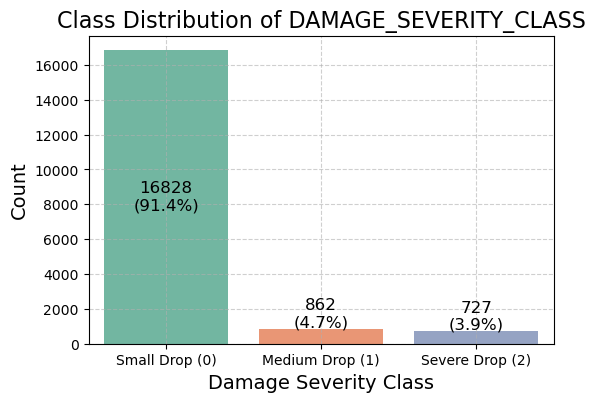

In [35]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=data, palette='Set2')

plt.title('Class Distribution of DAMAGE_SEVERITY_CLASS', fontsize=16)
plt.xlabel('Damage Severity Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([0,1,2], ['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)'])

counts = data['DAMAGE_SEVERITY_CLASS'].value_counts().sort_index()
percentages = data['DAMAGE_SEVERITY_CLASS'].value_counts(normalize=True).sort_index()

for i, (count, pct) in enumerate(zip(counts, percentages)):
    if i == 0:
        ax.text(i, count/2, f'{count}\n({pct:.1%})', ha='center', va='center', fontsize=12, color='black')
    else:
        ax.text(i, count + 100, f'{count}\n({pct:.1%})', ha='center', fontsize=12, color='black')

plt.show()


**Class Balance Analysis**   
The distribution of the DAMAGE_SEVERITY_CLASS variable reveals significant class imbalance (Figure X). Specifically, 91.4% of observations correspond to Small Drops (0), 4.7% to Medium Drops (1), and only 3.9% to Severe Drops (2). While this distribution reflects the natural rarity of severe market downturns following wildfire exposure, it poses challenges for classification model performance, particularly for minority classes. To address this, we plan to use evaluation metrics such as the Macro F1 Score and may explore class reweighting strategies to ensure balanced predictive performance across all severity categories.

## 2. Model Preparation

In [41]:
baseline_feature_cols = [
    'Median_Household_Income', 'Total_Population', 'Avg_Household_Size', 
    'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
    'Black_Portion', 'White_Portion', 'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
    'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_3yr_PRICE_CHANGE_STD'
]


TRAIN_YEAR_CUTOFF = 2020

train_df = data[data['YEAR'] <= TRAIN_YEAR_CUTOFF]
test_df = data[data['YEAR'] > TRAIN_YEAR_CUTOFF]

X_train = train_df[baseline_feature_cols]
y_train = train_df['DAMAGE_SEVERITY_CLASS']

X_test = test_df[baseline_feature_cols]
y_test = test_df['DAMAGE_SEVERITY_CLASS']



## 4. Baseline Majority Classifier

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# === Step 1: Baseline Naive Majority Classifier ===
majority_clf = DummyClassifier(strategy='most_frequent') 
majority_clf.fit(X_train, y_train)

# === Step 2: Predict on Test Set ===
y_pred_baseline = majority_clf.predict(X_test)

# === Step 3: Evaluate ===
print("=== Baseline Majority Classifier Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_baseline, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))


=== Baseline Majority Classifier Performance ===
Accuracy: 0.9767
Macro F1 Score: 0.3294

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.98      1.00      0.99      2686
Medium Drop (1)       0.00      0.00      0.00        22
Severe Drop (2)       0.00      0.00      0.00        42

       accuracy                           0.98      2750
      macro avg       0.33      0.33      0.33      2750
   weighted avg       0.95      0.98      0.97      2750


Confusion Matrix:
[[2686    0    0]
 [  22    0    0]
 [  42    0    0]]


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

**Baseline Model Analysis**  
The naive majority class classifier, which always predicts the Small Drop (0) category, achieved a high overall accuracy of 97.67% due to the dominant class imbalance. However, this high accuracy is misleading, as the Macro F1 Score was only 0.3294, indicating poor performance on minority classes (Medium and Severe Drops). The confusion matrix confirms that no Medium or Severe Drops were correctly identified. This baseline establishes a minimal threshold that our subsequent XGBoost models must substantially surpass, particularly in improving recall and F1 scores for minority classes.





## 5. XGBoost Majority Classifier (original)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [43]:
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [44]:
# Test Set prediction
y_pred_xgb = xgb_clf.predict(X_test_scaled)

print("=== XGBoost Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


=== XGBoost Model Performance ===
Accuracy: 0.9858
Macro F1 Score: 0.6454

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.99      1.00      0.99      2686
Medium Drop (1)       0.57      0.18      0.28        22
Severe Drop (2)       0.85      0.55      0.67        42

       accuracy                           0.99      2750
      macro avg       0.80      0.58      0.65      2750
   weighted avg       0.98      0.99      0.98      2750


Confusion Matrix:
[[2684    0    2]
 [  16    4    2]
 [  16    3   23]]


Compared to the naive majority class baseline, the XGBoost classifier achieved a substantial improvement in Macro F1 Score (0.6454 vs 0.3294), successfully identifying over half of Severe Drop cases and achieving an F1 Score of 0.67 for the most critical risk class. Although Medium Drop classification remains challenging, the model demonstrates strong potential for practical application in wildfire-exposed housing markets.  

The primary objective of this Economic Damage Severity classification model is to maximize recall for Medium and Severe Drops — ensuring that high-risk housing markets are flagged — even at the cost of some false positives.

**Evaluation Metrics**  
Given the extreme class imbalance in the dataset and the practical need to identify areas at risk of significant price declines, we selected the Macro F1 Score as the primary evaluation metric. Macro F1 equally weights precision and recall across all classes, ensuring that the model does not neglect minority classes such as Medium and Severe Drops. While Macro F1 requires a balance between precision and recall, our domain objective slightly prioritizes recall — favoring the early identification of high-risk areas even at the cost of some false positives.


## 6. XGBoost Majority Classifier (hyperparameter tuning)

**Feature Selection Strategy**  
Given the strong initial performance of the XGBoost model using baseline socioeconomic features (Macro F1 Score = 0.6454), we elected not to conduct feature selection prior to hyperparameter tuning. All available features were retained to preserve potential predictive signals, and tuning focused solely on optimizing learning parameters such as tree depth, learning rate, and number of estimators.

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 3]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_macro',  # use Macro F1 Score as metric
    cv=3,               
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Macro F1 Score:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


KeyboardInterrupt: 